In [112]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import sqlite3
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time,warnings

from sklearn.linear_model import LinearRegression


#explain the clusterization
import shap
shap.initjs()
warnings.filterwarnings("ignore")

In [113]:
conn = sqlite3.connect('../queries/retail.db')
df = pd.read_sql_query("SELECT * FROM mostvalue_client WHERE CustomerId IS NOT NULL", conn)
conn.close()

df.head()

,CustomerID,total_items,unique_items,avg_price,revenue,frequency,Country,total_days_appear,min_date,max_date,avg_date
0,14646.0,917,701,2.72,278571.62,1,Netherlands,1,1/14/2011 12:24,9/8/2011 11:28,6.822542
1,18102.0,208,150,4.94,259657.30,4,United Kingdom,5,10/21/2011 11:54,9/28/2011 16:17,8.676674
2,17450.0,179,125,3.89,189650.73,3,United Kingdom,3,1/11/2011 8:43,9/5/2011 13:52,6.792023
3,14911.0,2084,1793,3.37,132572.62,1,EIRE,1,1/18/2011 10:22,9/9/2011 11:57,8.159580
4,12415.0,515,443,2.36,123638.18,1,Australia,1,1/10/2011 9:58,9/1/2011 13:51,6.021851


In [114]:
global_max_date = pd.to_datetime(df['max_date']).max()
df['recency'] = (global_max_date - pd.to_datetime(df['max_date'])).dt.days
df.isnull().sum()
df.head()

RFM = df[['CustomerID','revenue', 'frequency', 'recency']].copy()

#rank customer based on revenue, frequency and recency
RFM['R_rank'] = RFM['recency'].rank(ascending=False)
RFM['F_rank'] = RFM['frequency'].rank(ascending=True)
RFM['M_rank'] = RFM['revenue'].rank(ascending=True)

RFM['R_rank_norm'] = (RFM['R_rank'] / RFM['R_rank'].max()) * 100
RFM['F_rank_norm'] = (RFM['F_rank'] / RFM['F_rank'].max()) * 100
RFM['M_rank_norm'] = (RFM['M_rank'] / RFM['M_rank'].max()) * 100

RFM.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
RFM.head()

#you can give the weights to the RFM variables: it depends on your business case (0 to 100 score)
RFM['RFM_Score'] = (RFM['R_rank_norm'] * 0.20) + (RFM['F_rank_norm'] * 0.20) + (RFM['M_rank_norm'] * 0.60)
RFM['RFM_Score'] = RFM['RFM_Score'].round(2)

rfm_cluster = RFM[['revenue', 'frequency', 'recency','RFM_Score']].copy()

RFM

,CustomerID,revenue,frequency,recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,14646.0,278571.62,1,92,59.022039,43.868898,100.00000,80.58
1,18102.0,259657.30,4,71,79.625803,98.819620,99.97708,95.68
2,17450.0,189650.73,3,94,56.875574,97.352739,99.95416,90.82
3,14911.0,132572.62,1,91,60.296143,43.868898,99.93124,80.79
4,12415.0,123638.18,1,98,53.810836,43.868898,99.90832,79.48
...,...,...,...,...,...,...,...,...
4358,12666.0,-227.44,1,358,3.937098,43.868898,0.11460,9.63
4359,16252.0,-295.09,1,365,2.502296,43.868898,0.09168,9.33
4360,16742.0,-464.90,1,46,87.190083,43.868898,0.06876,26.25
4361,15823.0,-796.86,1,371,0.952709,43.868898,0.04584,8.99


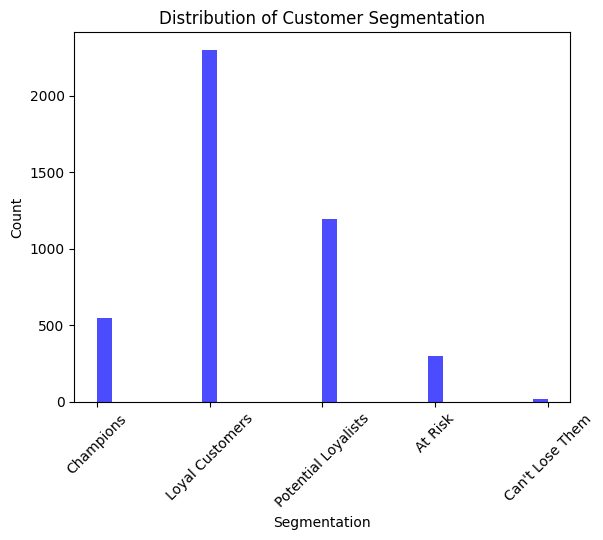

In [115]:
RFM['segmentation'] = np.where((RFM['RFM_Score'] >= 75), 'Champions',
                               np.where((RFM['RFM_Score'] >= 40) & (RFM['RFM_Score'] < 75), 'Loyal Customers',
                                        np.where((RFM['RFM_Score'] >= 20) & (RFM['RFM_Score'] < 40), 'Potential Loyalists',
                                                 np.where((RFM['RFM_Score'] >= 10) & (RFM['RFM_Score'] < 20), 'At Risk',
                                                          np.where((RFM['RFM_Score'] >= 5) & (RFM['RFM_Score'] < 10), 'Can\'t Lose Them',
                                                                   np.where((RFM['RFM_Score'] >= 1) & (RFM['RFM_Score'] < 5), 'Lost', 'New'))))))
RFM['segmentation'] = RFM['segmentation'].astype('category')


plt.hist(RFM['segmentation'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Segmentation')
plt.ylabel('Count')
plt.title('Distribution of Customer Segmentation')
plt.xticks(rotation=45)
plt.show()

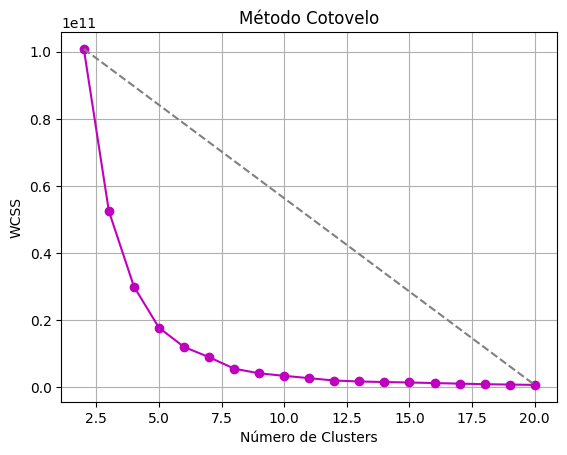

In [116]:

def calculate_wcss(data):
    wcss = []

    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    return wcss

wcss = calculate_wcss(rfm_cluster)
plt.plot(range(2,21), wcss, marker='o', color='m')
plt.plot([2, 20], [wcss[0], wcss[-1]], color='gray', linestyle='--')
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método Cotovelo')
plt.show()


Estamos procurando o ponto que indica o maior equilíbrio entre maior homogeneidade dentro do cluster e a mior diferenca entre clusters, é o ponto da curva mais distante de uma reta tracaada entre os ponto (2, 20)

E temos a formula que calcula essa maior distância no nosso modelo: 

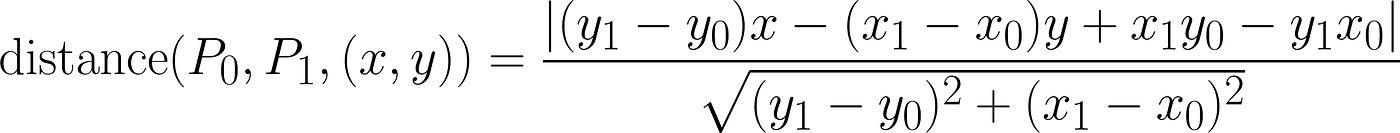

O nosso P0 é nosso: 2
O nosso P1 é nosso: 20

In [117]:
def good_optional_cluster(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[-1]

    distance = []

    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distance.append(numerator / denominator)
    
    return distance.index(max(distance)) + 2

In [118]:
n = good_optional_cluster(wcss)
print(f'Número ótimo: {n} Clusters')

Número ótimo: 6 Clusters


In [119]:
kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
kmeans.fit(rfm_cluster)

rfm_cluster['Cluster'] = kmeans.labels_ + 1

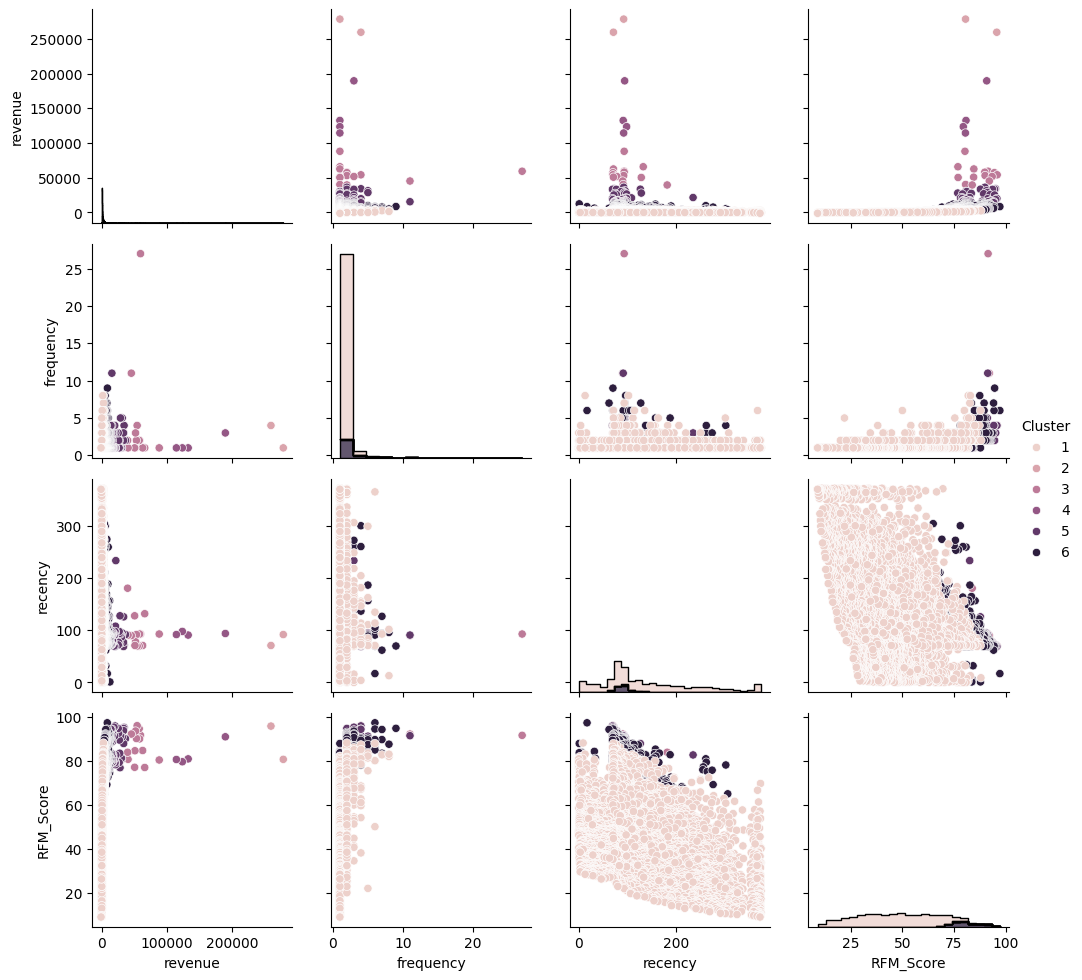

In [120]:
g = sns.PairGrid(rfm_cluster, hue="Cluster")
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_offdiag(sns.scatterplot)
g.add_legend()


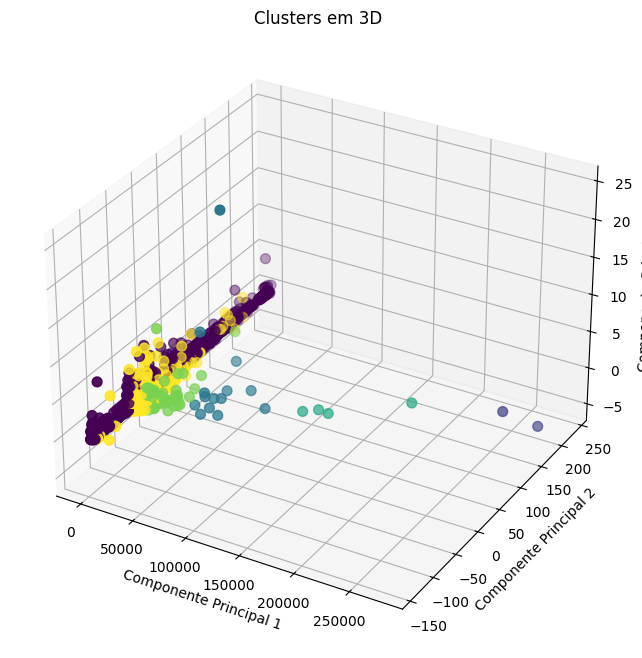

In [122]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(rfm_cluster[['revenue', 'frequency', 'recency']])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=rfm_cluster['Cluster'], cmap='viridis', s=50)
plt.title('Clusters em 3D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.show()

## Approach for cluster, it depends what is your goals, your main metric for you strategies

* I was thinking about the different approach of the clusterization, i have conclusion how mean the metrics are importance for the bussiness case. when you understand the business case, you can give the weights to the RFM variables and during the process you have possibility to define the metrics in e.g you campaign.

* So last conclusion you can use different approach of the clusterization, but remember what is the goals you need achieve.